<a href="https://colab.research.google.com/github/lukasakar19-byte/Tugas-MRA/blob/main/Hands_On_Classification_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

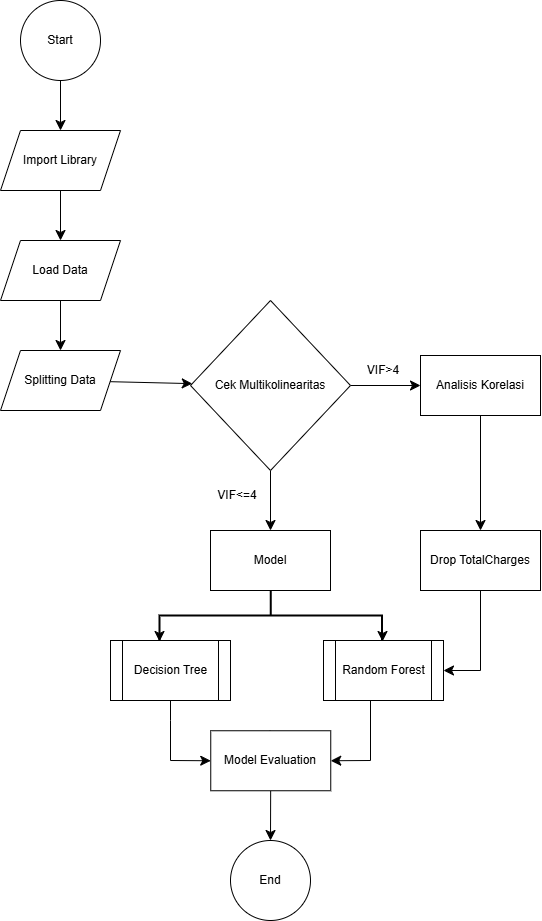

# Classification Models

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Decision Tree

In [ ]:
import os

from google.colab import drive
drive.mount('/content/gdrive')
# load dataset
purchase = pd.read_csv('/content/gdrive/My Drive/MRA/Tugas/classification_data.csv')
purchase.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,age,salary,purchased
0,19,19000,0
1,35,20000,0
2,26,43000,0
3,27,57000,0
4,19,76000,0


In [ ]:
# sanity checks nilai unik dari kolom purchased
purchase['purchased'].unique()

array([0, 1])

In [ ]:
# split data
from sklearn.model_selection import train_test_split

feature = purchase.drop(columns='purchased')
target = purchase[['purchased']]

feature_purchase_train, feature_purchase_test, target_purchase_train, target_purchase_test = train_test_split(feature, target, test_size=0.20, random_state=42)

In [ ]:
# multicollinearity check
# calculate vif score for each feature column
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

X = add_constant(feature_purchase_train)

vif_df = (pd.DataFrame(
            [vif(X.values, i) for i in range(len(X.columns))]
            ,index=X.columns)
            .reset_index())

vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,age,1.020623
2,salary,1.020623


karena vif score ≤ 4, maka aman dari multikolinearity

In [ ]:
# convert data into numpy arrays
X_purchase_train = feature_purchase_train.to_numpy()
y_purchase_train = target_purchase_train.to_numpy().ravel()

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# define the model
dectree = DecisionTreeClassifier(random_state=42)

# train the model
dectree.fit(X_purchase_train, y_purchase_train)

DecisionTreeClassifier(random_state=42)

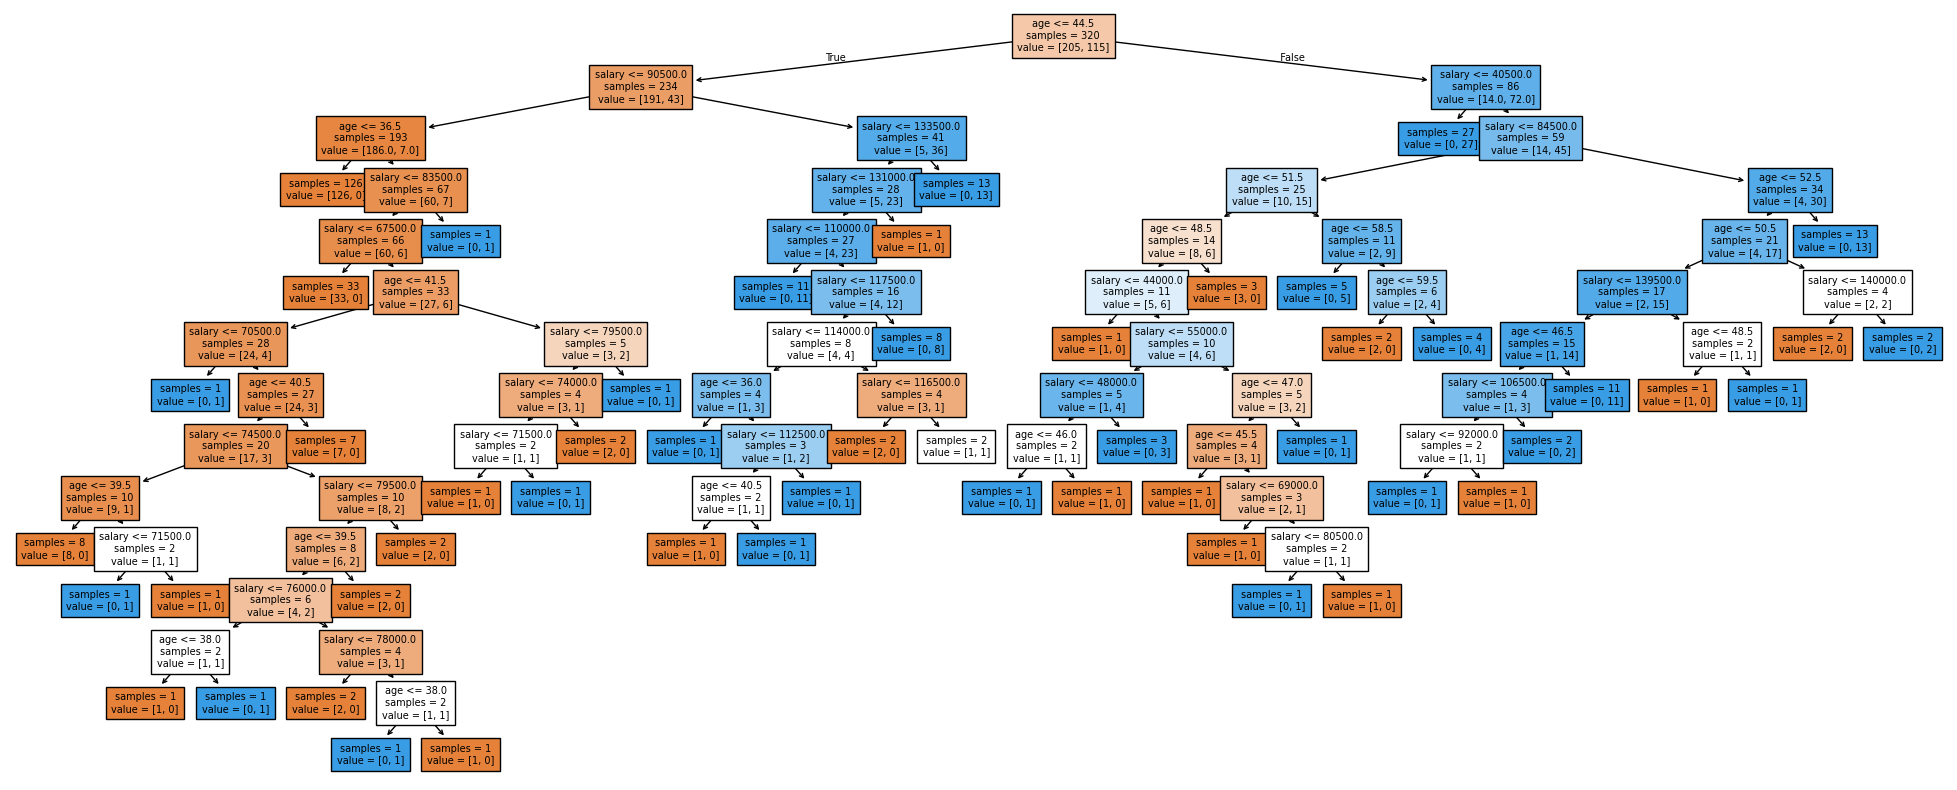

In [ ]:
# menggambar decision tree yang didapat
from sklearn.tree import plot_tree
plt.figure(figsize=(25, 10))
plot_tree(
    dectree,
    feature_names=['age',"salary"],
    impurity=False,
    filled=True,
    fontsize=7
)
plt.show()

ini adalah ilustrasi decision treenya

In [ ]:
# decision rules dalam bentuk tertulis
from sklearn.tree import export_text

r = export_text(dectree, feature_names=feature_purchase_train.columns.tolist())
print(r)

|--- age <= 44.50
|   |--- salary <= 90500.00
|   |   |--- age <= 36.50
|   |   |   |--- class: 0
|   |   |--- age >  36.50
|   |   |   |--- salary <= 83500.00
|   |   |   |   |--- salary <= 67500.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- salary >  67500.00
|   |   |   |   |   |--- age <= 41.50
|   |   |   |   |   |   |--- salary <= 70500.00
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- salary >  70500.00
|   |   |   |   |   |   |   |--- age <= 40.50
|   |   |   |   |   |   |   |   |--- salary <= 74500.00
|   |   |   |   |   |   |   |   |   |--- age <= 39.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- age >  39.50
|   |   |   |   |   |   |   |   |   |   |--- salary <= 71500.00
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |   |--- salary >  71500.00
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- salar

decision tree dalam bentuk text

Decision tree memulai pemisahan berdasarkan usia karena variabel tersebut memiliki pengaruh paling besar. Individu dengan usia ≤44,5 tahun selanjutnya dipisahkan berdasarkan salary, di mana salary rendah hingga menengah cenderung menghasilkan kelas 0, sedangkan salary tinggi (≥90.500) cenderung menghasilkan kelas 1.

# Hitung akurasi pada data train dan data test

In [ ]:
# accuracy score on training data
from sklearn.metrics import accuracy_score

y_predict_train = dectree.predict(X_purchase_train)

print(f"Accuracy on training data is {accuracy_score(y_purchase_train,y_predict_train)}")

Accuracy on training data is 0.996875


In [ ]:
# prepare test data as numpy arrays
X_purchase_test = feature_purchase_test.to_numpy()
y_purchase_test = target_purchase_test.to_numpy().ravel()

In [ ]:
# accuracy score on test data
y_predict_test = dectree.predict(X_purchase_test)

print(f"Accuracy on test data is {accuracy_score(y_purchase_test,y_predict_test)}")

Accuracy on test data is 0.8375


Model menghasilkan akurasi training sebesar 99.69% dan akurasi testing 83.75%. Perbedaan ini menunjukkan adanya indikasi overfitting. Overfitting terjadi karena model menghasilkan akurasi yang sangat tinggi pada data training (99.69%) namun jauh lebih rendah pada data test (83.75%). Perbedaan yang besar ini menunjukkan bahwa model terlalu menyesuaikan diri dengan data training.

## Random Forest

In [ ]:
purchase.head()

,age,salary,purchased
0,19,19000,0
1,35,20000,0
2,26,43000,0
3,27,57000,0
4,19,76000,0


In [ ]:
# cek distribusi label
purchase['purchased'].value_counts()

,count
purchased,
0,257
1,143


Dataset ini imbalanced karena kelas 0 jauh lebih banyak dari kelas 1. Di sini kita akan pakai presisi daripada akurasi, akurasi tidak dipakai karena model bisa terlihat baik hanya dengan menebak kelas data yang lebih banyak. Karena itu dipakai presisi untuk memaksimalkan confidence pada prediksi purchased, yang lebih menggambarkan kualitas prediksi pada kelas data yang lebih sedikit (purchased = 1).

# Evaluasi Model Random Forest pada Data Imbalance

In [ ]:
# train random forest model
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 10, random_state=42)
rf.fit(X_purchase_train, y_purchase_train)

RandomForestClassifier(n_estimators=10, random_state=42)

In [ ]:
# classification report on training data
from sklearn.metrics import classification_report

y_predict_train = rf.predict(X_purchase_train)

print(classification_report(y_purchase_train,y_predict_train))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       205
           1       1.00      0.96      0.98       115

    accuracy                           0.98       320
   macro avg       0.99      0.98      0.98       320
weighted avg       0.98      0.98      0.98       320



In [ ]:
# classification report on test data
from sklearn.metrics import classification_report

y_predict_test = rf.predict(X_purchase_test)

print(classification_report(y_purchase_test,y_predict_test))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90        52
           1       0.80      0.86      0.83        28

    accuracy                           0.88        80
   macro avg       0.86      0.87      0.86        80
weighted avg       0.88      0.88      0.88        80



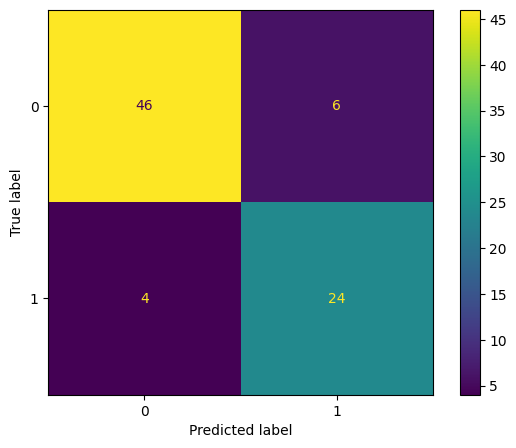

In [ ]:
# plotting confusion matrix on test data
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(7,5))

cm = confusion_matrix(y_purchase_test, y_predict_test,
                      labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf.classes_)
disp.plot(ax=ax)
plt.show()

Berdasarkan confusion matrix, model ini punya presisi yang cukup tinggi di kedua kelas. Untuk kelas 0, setiap kali model memprediksi “0”, sekitar 92% di antaranya benar. Sementara untuk kelas 1, presisinya sekitar 80%, artinya sebagian besar prediksi “1” juga akurat. Jadi secara keseluruhan, model sudah cukup baik dalam mengeluarkan prediksi

## Random Forest on Telco Churn Data

In [ ]:
#load data
telco = pd.read_csv('/content/gdrive/My Drive/MRA/Tugas/telco_processed.csv')
telco.head()

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,log_DataQuota,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0.0,0,0,34.0,0,56.95,1889.50,0,0.930868,0,1,0,0,0,0,1
1,1,0.0,0,0,2.0,1,53.85,108.15,1,1.323844,1,0,0,0,0,0,1
2,1,0.0,0,0,45.0,0,42.30,1840.75,0,1.761515,0,1,0,1,0,0,0
3,0,0.0,0,0,2.0,1,70.70,151.65,1,0.882923,1,0,0,0,0,1,0
4,0,0.0,0,0,8.0,1,99.65,820.50,1,0.882932,1,0,0,0,0,1,0


In [ ]:
# cek distribusi target
telco['Churn'].value_counts()

,count
Churn,
0,5034
1,1809


Imbalanced, tidak boleh pakai akurasi. Kita akan pakai **recall** untuk memaksimalkan coverage capturing potential user yang akan churn.

In [ ]:
# train test split
from sklearn.model_selection import train_test_split

feature = telco.drop(columns='Churn')
target = telco[['Churn']]

X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.20, random_state=42)

In [ ]:
X_train.columns.tolist()

['Gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'Tenure',
 'PaperlessBilling',
 'MonthlyCharges',
 'TotalCharges',
 'log_DataQuota',
 'Contract_Month-to-month',
 'Contract_One year',
 'Contract_Two year',
 'PaymentMethod_Bank transfer (automatic)',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check']

In [ ]:
# multicollineary handling
# calculate vif score for each column
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

cols = ['Gender',
        'SeniorCitizen',
        'Partner',
        'Dependents',
        'Tenure',
        'PaperlessBilling',
        'MonthlyCharges',
        'TotalCharges',
        'log_DataQuota']

X = add_constant(X_train[cols])

vif_df = (pd.DataFrame(
            [vif(X.values, i) for i in range(len(X.columns))]
            ,index=X.columns)
            .reset_index())

vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,Gender,1.000869
2,SeniorCitizen,1.124415
3,Partner,1.452820
4,Dependents,1.366163
5,Tenure,5.919101
6,PaperlessBilling,1.172685
7,MonthlyCharges,3.545266
8,TotalCharges,9.458412
9,log_DataQuota,1.002109


Terdapat vif_score ≥ 4, yaitu Tenure dan TotalCharges, maka lakukan analisis korelasi

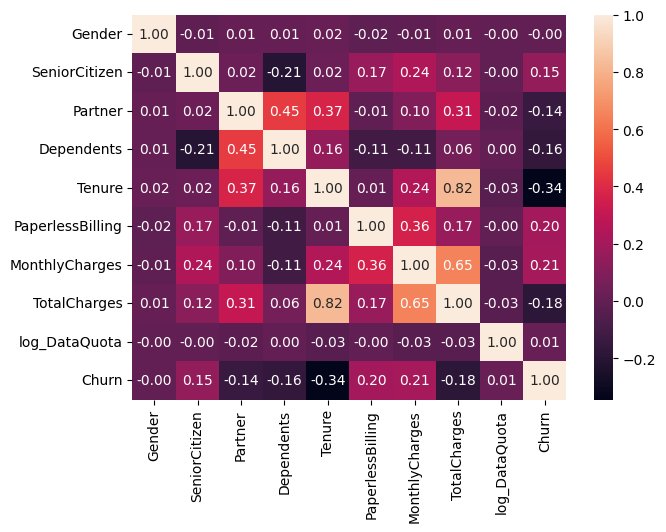

In [ ]:
# heatmap correlation
train = pd.concat([X_train[cols], y_train], axis=1)
corr = train.corr()

plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

Drop TotalCharges

In [ ]:
# Drop TotalCharges from training and test data
X_train = X_train.drop(columns='TotalCharges')
X_test = X_test.drop(columns='TotalCharges')

In [ ]:
# convert to numpy arrays
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

y_train = y_train.to_numpy().ravel()
y_test = y_test.to_numpy().ravel()

In [ ]:
# train random forest model
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 25, random_state = 42)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=25, random_state=42)

In [ ]:
# classification report on training data
from sklearn.metrics import classification_report

y_predict_train = rf.predict(X_train)

print(classification_report(y_train,y_predict_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4048
           1       1.00      0.99      1.00      1426

    accuracy                           1.00      5474
   macro avg       1.00      1.00      1.00      5474
weighted avg       1.00      1.00      1.00      5474



In [ ]:
# classification report on test data
from sklearn.metrics import classification_report

y_predict_test = rf.predict(X_test)

print(classification_report(y_test,y_predict_test))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       986
           1       0.62      0.49      0.55       383

    accuracy                           0.77      1369
   macro avg       0.72      0.69      0.70      1369
weighted avg       0.76      0.77      0.77      1369



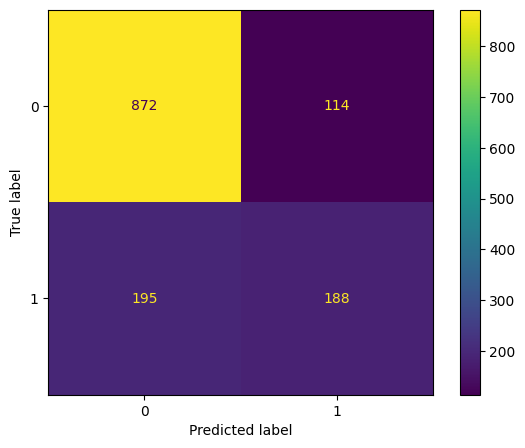

In [ ]:
# plotting confusion matrix on test data
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(7,5))

cm = confusion_matrix(y_test, y_predict_test, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf.classes_)
disp.plot(ax=ax)
plt.show()

Dari confusion matrix kelihatan kalau model ini lebih gampang ngenalin kelas 0 dibanding kelas 1. FN-nya cukup banyak (195), jadi banyak kasus kelas 1 yang kelewat. Kalau pakai rumus recall:

$\text{Recall} = \frac{TP}{TP + FN} = \frac{188}{188+195} = 0.49$

Jadi recall kelas 1 masih rendah, cuma sekitar 49%, yang berarti model belum cukup bagus buat kelas minoritas di data yang imbalanced.

# Selesai